In [1]:
import os
from neo.io import AxonIO
import matplotlib.pyplot as plt
import numpy as np


#### Configuring paths and variables

In [11]:
#abf_file_path = os.path.abspath("./HH0806190AB.abf") 
#abf_file_path = os.path.abspath("./HH0804170AA.abf") 
#abf_file_path = os.path.abspath("./HH0804220AB.abf") 
abf_file_path = os.path.abspath("./HH0805130AP.abf") 
#abf_file_path = os.path.abspath("./HH0805230AI.abf") 

rec_name = abf_file_path.split('\\')[-1][:-4]
abf_metadata = {'recording_name':rec_name, 'ch_soma_voltage':1, 'ch_soma_current':2, 'ch_dend_voltage':3, 'ch_soma_voltage_name':'Channel Adc0', 'stim_start':0.6102, 'stim_end':1.6100, 'stim_amps':[]}

save_dir_figs = os.path.abspath(f"./Figures/{abf_metadata['recording_name']}")
if not os.path.exists(save_dir_figs):
    os.makedirs(save_dir_figs)
    
save_dir_data = os.path.abspath(f"./KOKI_format/{abf_metadata['recording_name']}")
if not os.path.exists(save_dir_data):
    os.makedirs(save_dir_data)
    
plot_figures = False
save_figures = True

#### Load the ABF file

In [12]:
# ! this file cannot be loaded with pyabf - ValueError: Support for float data is not implemented (in pyabf)
# I tried exporting it to ABF integer format and use that but unfortunately this conversion messes up the file real bad
# also tried exporting to ATF - but it results in a loss of precision - so i will load it with neo

reader = AxonIO(filename=abf_file_path)
block = reader.read_block(lazy=False)
print(f"Loaded {abf_metadata['recording_name']}.abf")

num_sweeps = len(block.segments)
print("Number of sweeps:", num_sweeps)

time_in_sec = block.segments[0].analogsignals[0].times[-1]
print('Length of sweeps:', time_in_sec)
time_vec = block.segments[0].analogsignals[0].times

soma_voltage_all = []
soma_current_all = []
dend_voltage_all = []
for sweep in range(num_sweeps):
    voltage_data = block.segments[sweep].analogsignals[0]
    soma_voltage_data = []
    dend_voltage_data = []
    for row in voltage_data:
        soma_voltage_data.append(float(row[0]))
        dend_voltage_data.append(float(row[1]))  
    soma_voltage_all.append(soma_voltage_data)
    dend_voltage_all.append(dend_voltage_data)
    current_data = block.segments[sweep].analogsignals[1]
    soma_current_data = []
    for row in current_data:
        soma_current_data.append(float(row[0]))   
    soma_current_all.append(soma_current_data)

Loaded HH0805130AP.abf
Number of sweeps: 20
Length of sweeps: 2.359975 s


#### Calculating the stim amplitudes

In [13]:
if not abf_metadata['stim_amps']:
    abf_metadata['samp_freq'] = block.segments[0].analogsignals[0].sampling_rate.magnitude
    print('Sampling frequency:', abf_metadata['samp_freq'])
    stim_start = int(abf_metadata['stim_start']*abf_metadata['samp_freq'])
    stim_end = int(abf_metadata['stim_end']*abf_metadata['samp_freq'])
    #print(stim_start)
    #print(stim_end)
    
    for sweep in range(num_sweeps):
        
        soma_current_data = soma_current_all[sweep]
        stim_amp = round(np.mean(soma_current_data[stim_start:stim_end]), 4)
        stim_amp_sd = round(np.std(soma_current_data[stim_start:stim_end]), 4)
        abf_metadata['stim_amps'].append({'value':stim_amp, 'sd':stim_amp_sd})   
    
    print('Stim amps:', abf_metadata['stim_amps'])

else:
    print('Stim amplitudes already calculated')
    print('Stim amps:', abf_metadata['stim_amps'])

Sampling frequency: 40000.0
Stim amps: [{'value': -78.4142, 'sd': 0.7843}, {'value': -28.2471, 'sd': 0.9849}, {'value': 21.506, 'sd': 0.8469}, {'value': 71.6735, 'sd': 0.8436}, {'value': 122.0527, 'sd': 0.8859}, {'value': 171.8137, 'sd': 0.9369}, {'value': 221.9295, 'sd': 0.7823}, {'value': 272.5249, 'sd': 0.8606}, {'value': 322.1343, 'sd': 0.9264}, {'value': 372.6748, 'sd': 0.8181}, {'value': 422.7168, 'sd': 0.8956}, {'value': 472.2999, 'sd': 0.9164}, {'value': 523.1313, 'sd': 0.8614}, {'value': 572.807, 'sd': 0.8582}, {'value': 622.7055, 'sd': 0.8276}, {'value': 673.7395, 'sd': 0.8848}, {'value': 724.3551, 'sd': 0.8775}, {'value': 773.306, 'sd': 0.8412}, {'value': 824.4887, 'sd': 0.908}, {'value': 875.1276, 'sd': 0.8532}]


### Converting to KOKI format


#### Creating the protocol file

In [49]:
path_protocol = os.path.join(save_dir_data, 'protocol.txt')

stim_amps_final = ' '.join(str(x) for x in range(-180, 771, 50))
print(stim_amps_final)

with open(path_protocol, 'w') as protocol_file:
    protocol_file.write('soma-dend protocol' + "\n") 
    protocol_file.write(f"ch{abf_metadata['ch_soma_voltage']}\n") 
    protocol_file.write(str(abf_metadata['samp_freq']) + "\n") 
    protocol_file.write(str(round(abf_metadata['stim_start']*1000, 1)) + " " + str(round(abf_metadata['stim_end']*1000, 2)) + " " + str(round(float(time_in_sec)*1000, 2)) + "\n")
    #protocol_file.write(' '.join([str(entry['value']) for entry in abf_metadata['stim_amps']]) + "\n")
    protocol_file.write(stim_amps_final + "\n")
    protocol_file.write(f"dend voltage: ch{abf_metadata['ch_dend_voltage']}")
    
print(protocol_file)

-180 -130 -80 -30 20 70 120 170 220 270 320 370 420 470 520 570 620 670 720 770
<_io.TextIOWrapper name='C:\\Users\\Bogi\\Documents\\KOKI\\PVBC_models_evaluation\\Hu_adatok\\Files\\KOKI_format\\HH0806190AB\\protocol.txt' mode='w' encoding='cp1250'>


#### Creating the KOKI format soma voltage data txt

In [50]:
path_voltage_data = os.path.join(save_dir_data, f"{abf_metadata['recording_name']}_ch{abf_metadata['ch_soma_voltage']}.txt")

transposed_lists = zip(*soma_voltage_all)    # transpose the lists

column_width = 20
with open(path_voltage_data, 'w') as file:
    for row in transposed_lists:
        # Format each value with the specified width and align to the right
        formatted_row = [f"{value:>{column_width}}" for value in row]
        # Join the formatted values with tabs and write the row to the file
        file.write('\t'.join(formatted_row) + '\n')

#### Creating the KOKI format soma current data txt

In [51]:
path_current_data = os.path.join(save_dir_data, f"{abf_metadata['recording_name']}_ch{abf_metadata['ch_soma_current']}.txt")

transposed_lists = zip(*soma_current_all)    # transpose the lists

column_width = 20
with open(path_current_data, 'w') as file:
    for row in transposed_lists:
        # Format each value with the specified width and align to the right
        formatted_row = [f"{value:>{column_width}}" for value in row]
        # Join the formatted values with tabs and write the row to the file
        file.write('\t'.join(formatted_row) + '\n')

#### Creating the KOKI format dend voltage data txt

In [52]:
path_dend_voltage_data = os.path.join(save_dir_data,
                                 f"{abf_metadata['recording_name']}_ch{abf_metadata['ch_dend_voltage']}.txt")

transposed_lists = zip(*dend_voltage_all)  # transpose the lists

column_width = 20
with open(path_dend_voltage_data, 'w') as file:
    for row in transposed_lists:
        # Format each value with the specified width and align to the right
        formatted_row = [f"{value:>{column_width}}" for value in row]
        # Join the formatted values with tabs and write the row to the file
        file.write('\t'.join(formatted_row) + '\n')

#### Calculating the mean soma current and voltage outside the stimulus

[{'value': 23.13, 'std': 0.81}, {'value': 23.27, 'std': 0.85}, {'value': 23.05, 'std': 0.83}, {'value': 22.9, 'std': 0.85}, {'value': 23.03, 'std': 0.84}, {'value': 23.07, 'std': 0.83}, {'value': 23.06, 'std': 0.85}, {'value': 23.27, 'std': 0.85}, {'value': 22.98, 'std': 0.85}, {'value': 22.83, 'std': 0.86}, {'value': 23.11, 'std': 0.85}, {'value': 22.85, 'std': 0.84}, {'value': 22.91, 'std': 0.84}, {'value': 23.11, 'std': 0.85}, {'value': 22.87, 'std': 0.86}, {'value': 22.97, 'std': 0.83}, {'value': 23.15, 'std': 0.85}, {'value': 23.03, 'std': 0.84}, {'value': 23.17, 'std': 0.85}, {'value': 23.31, 'std': 0.87}, {'value': 23.15, 'std': 0.84}, {'value': 23.24, 'std': 0.85}, {'value': 23.29, 'std': 0.85}, {'value': 23.3, 'std': 0.88}, {'value': 23.2, 'std': 0.86}, {'value': 23.46, 'std': 0.86}, {'value': 23.06, 'std': 0.83}, {'value': 23.08, 'std': 0.86}, {'value': 23.1, 'std': 0.86}, {'value': 22.94, 'std': 0.86}, {'value': 22.85, 'std': 0.84}, {'value': 23.08, 'std': 0.85}, {'value': 2

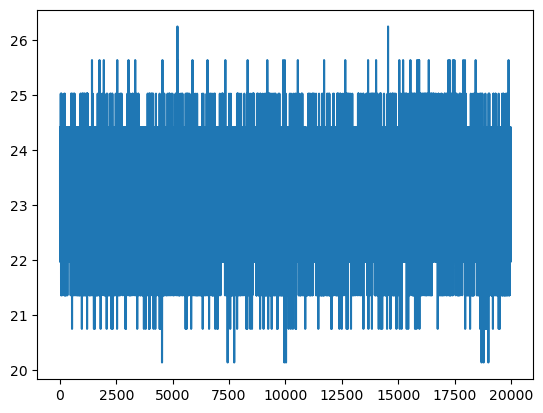

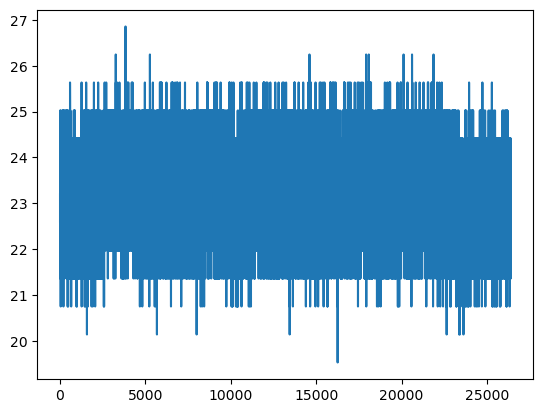

In [5]:
outside_stim_before = int(0.5*abf_metadata['samp_freq'])
outside_stim_after = int(1.7*abf_metadata['samp_freq'])  
outside_stim_current_means = []
before_stim_current_means = []
after_stim_current_means = []

for i in range(num_sweeps):
    # before stim
    mean_no_stim_current = round(np.mean(soma_current_all[i][0:outside_stim_before]), 2)
    std_no_stim_current = round(np.std(soma_current_all[i][0:outside_stim_before]), 2)
    before_stim_current_means.append({'value':mean_no_stim_current, 'std':std_no_stim_current})
    outside_stim_current_means.append({'value':mean_no_stim_current, 'std':std_no_stim_current})
    # after stim
    mean_no_stim_current = round(np.mean(soma_current_all[i][outside_stim_after:]), 2)
    std_no_stim_current = round(np.std(soma_current_all[i][outside_stim_after:]), 2)
    after_stim_current_means.append({'value':mean_no_stim_current, 'std':std_no_stim_current})
    outside_stim_current_means.append({'value':mean_no_stim_current, 'std':std_no_stim_current})
    

print(outside_stim_current_means)
print('Mean amplitude of the current BEFORE stim:', round(np.mean([d['value'] for d in before_stim_current_means]), 2))
print('Mean amplitude of the current AFTER stim:', round(np.mean([d['value'] for d in after_stim_current_means]), 2))
print('Overall mean and std of the outside-stimulus current:', round(np.mean([d['value'] for d in outside_stim_current_means]), 2), round(np.std([d['value'] for d in outside_stim_current_means]), 2))

# Plot an example
plt.figure()
plt.plot(range(0,len(soma_current_all[0][0:outside_stim_before])), soma_current_all[0][0:outside_stim_before])
plt.show()
plt.figure()
plt.plot(range(0,len(soma_current_all[0][outside_stim_after:])), soma_current_all[0][outside_stim_after:])
plt.show()


#### Plot and save figures if needed

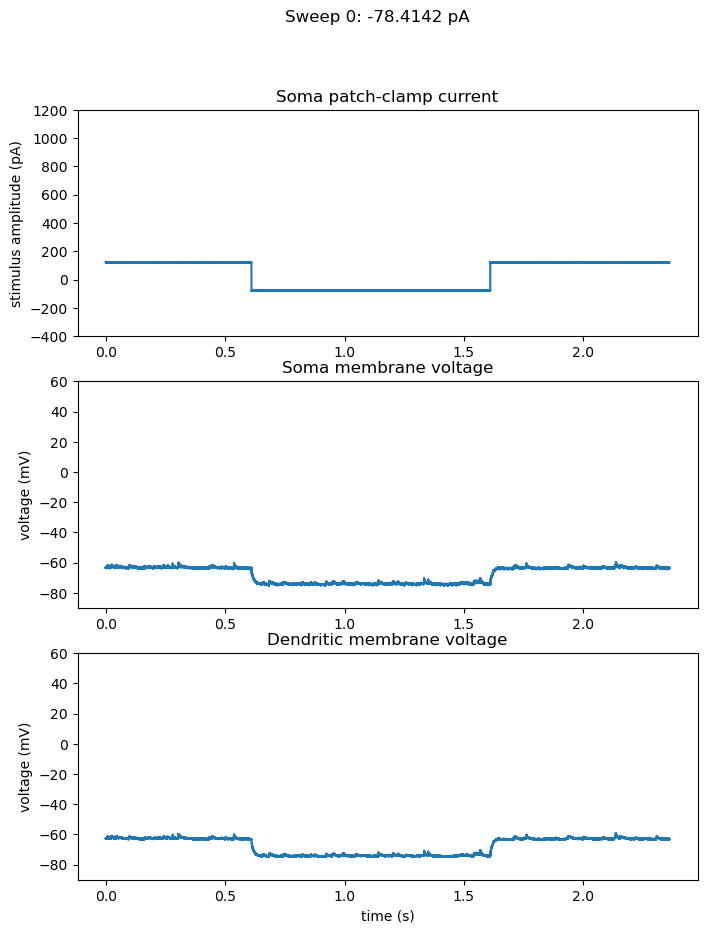

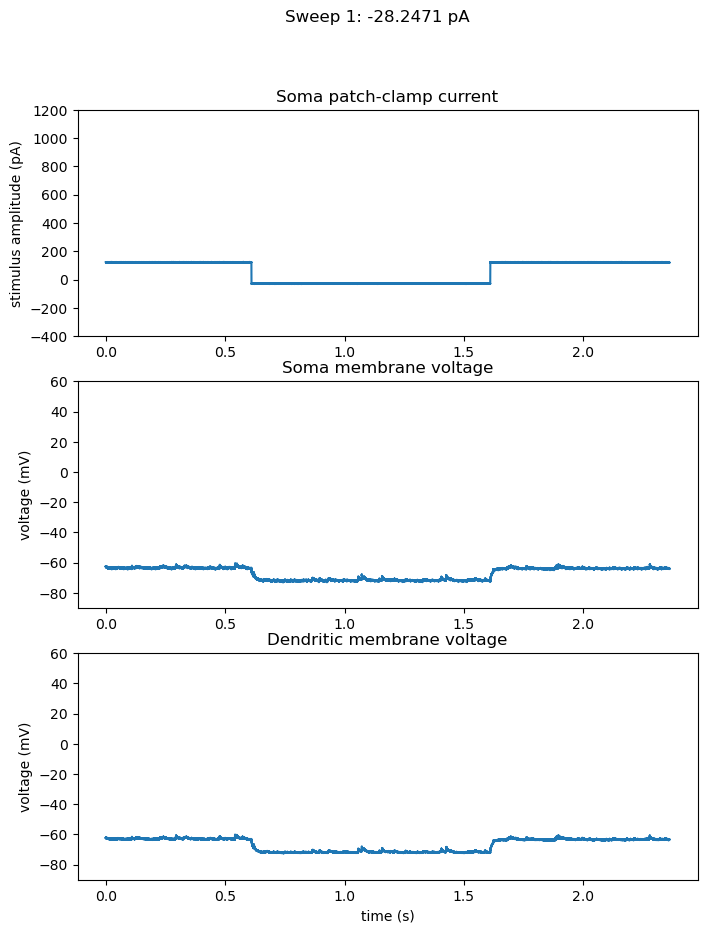

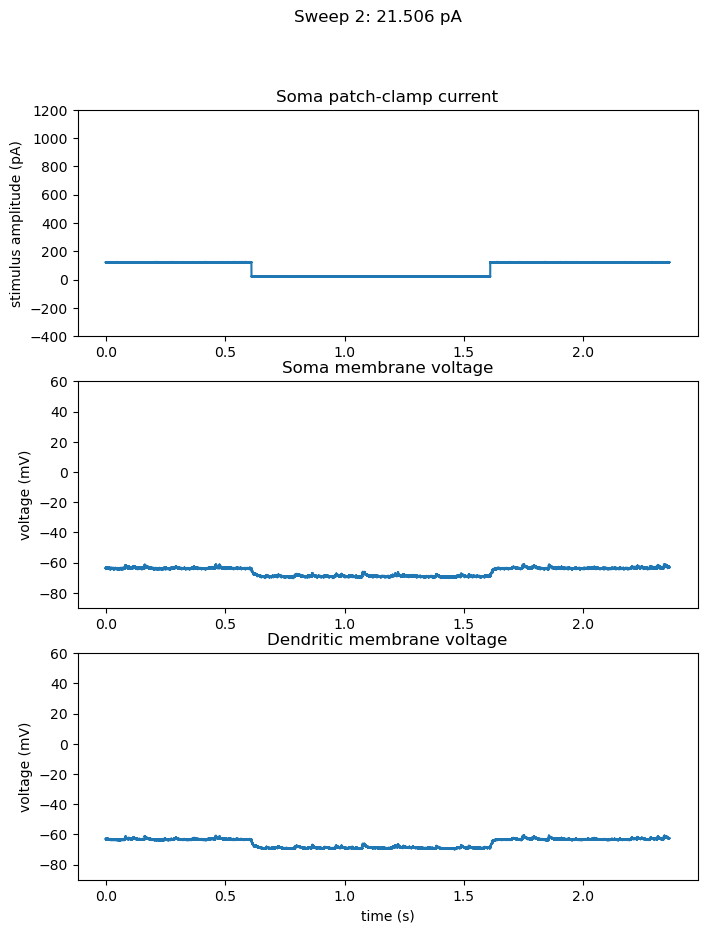

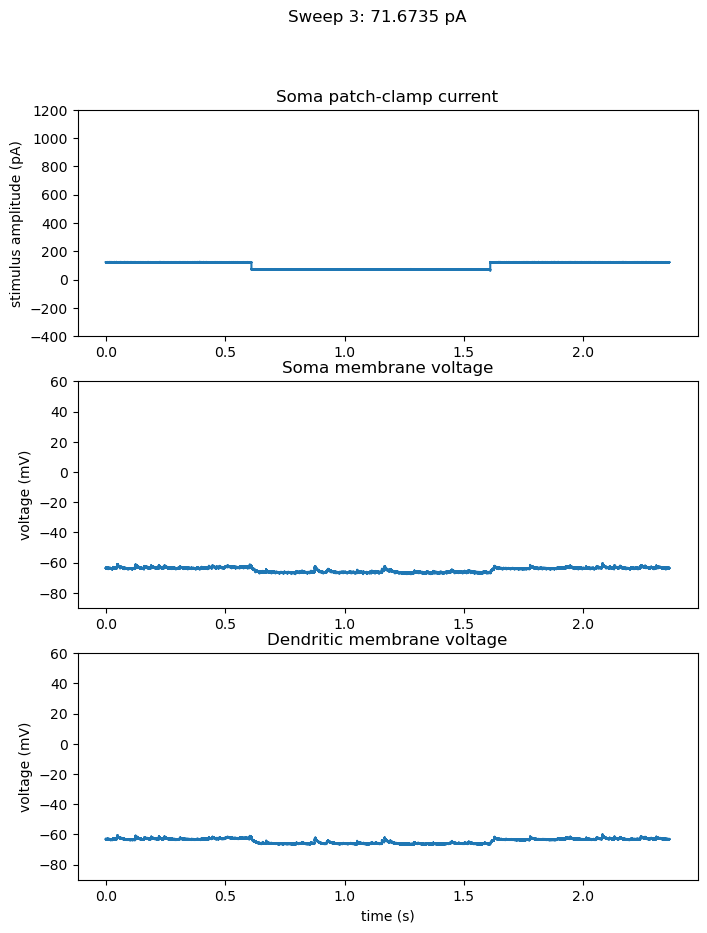

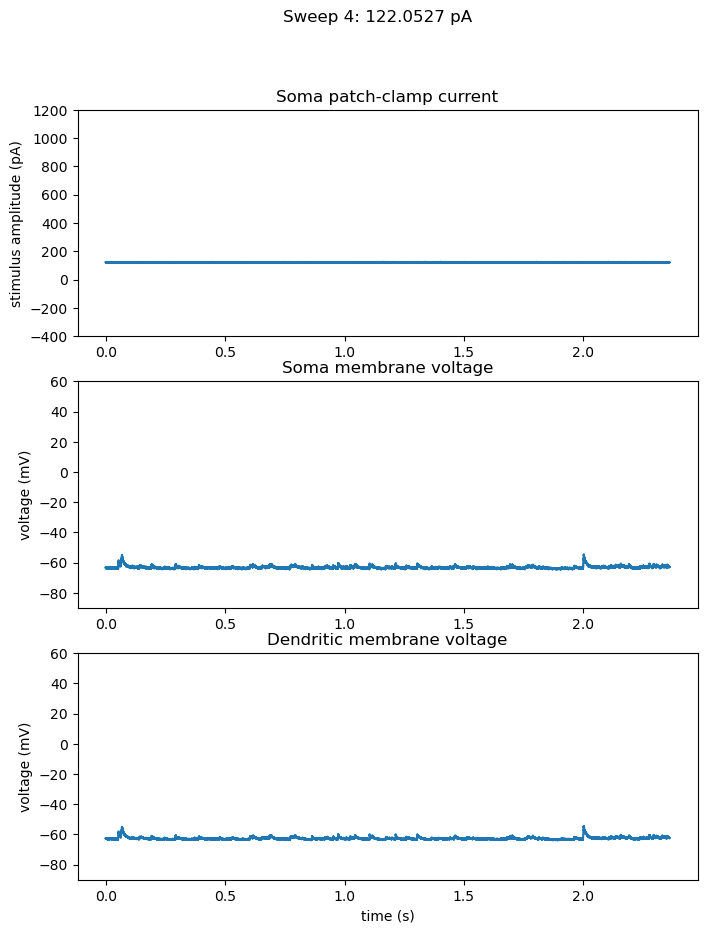

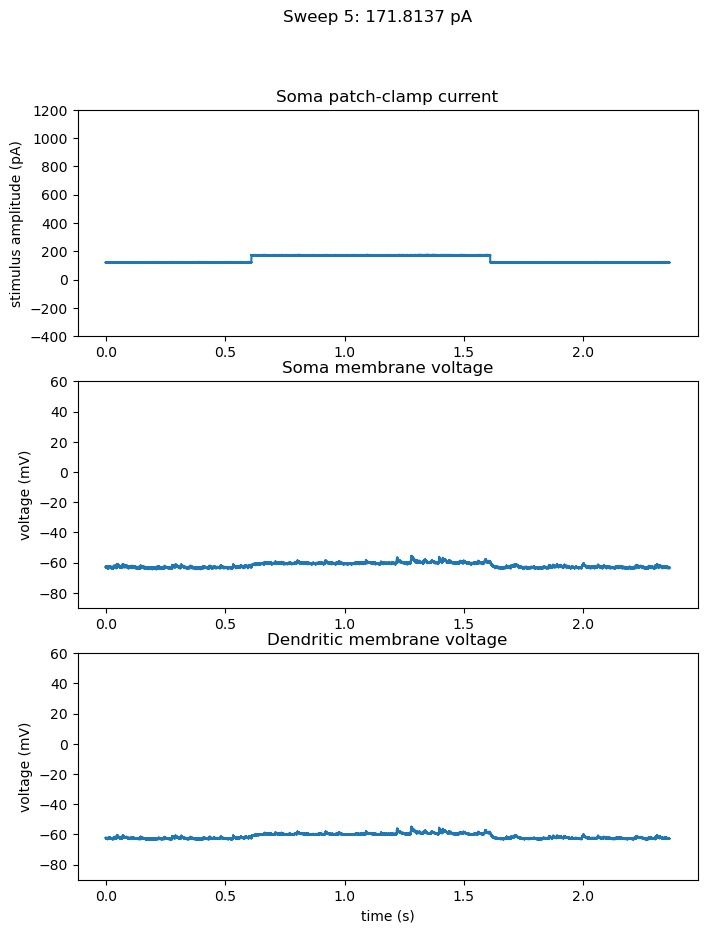

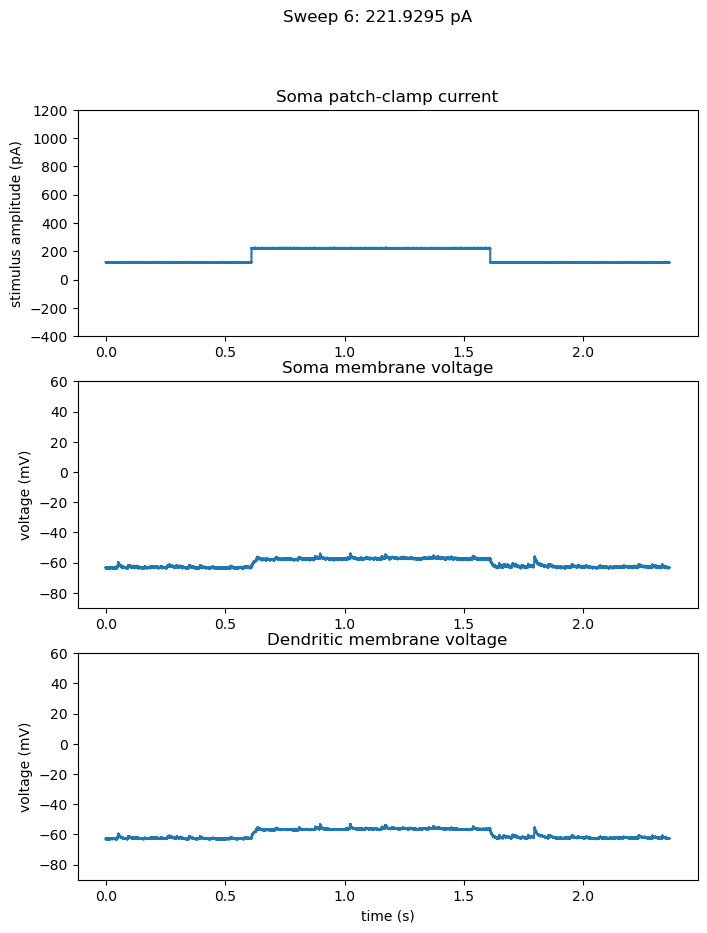

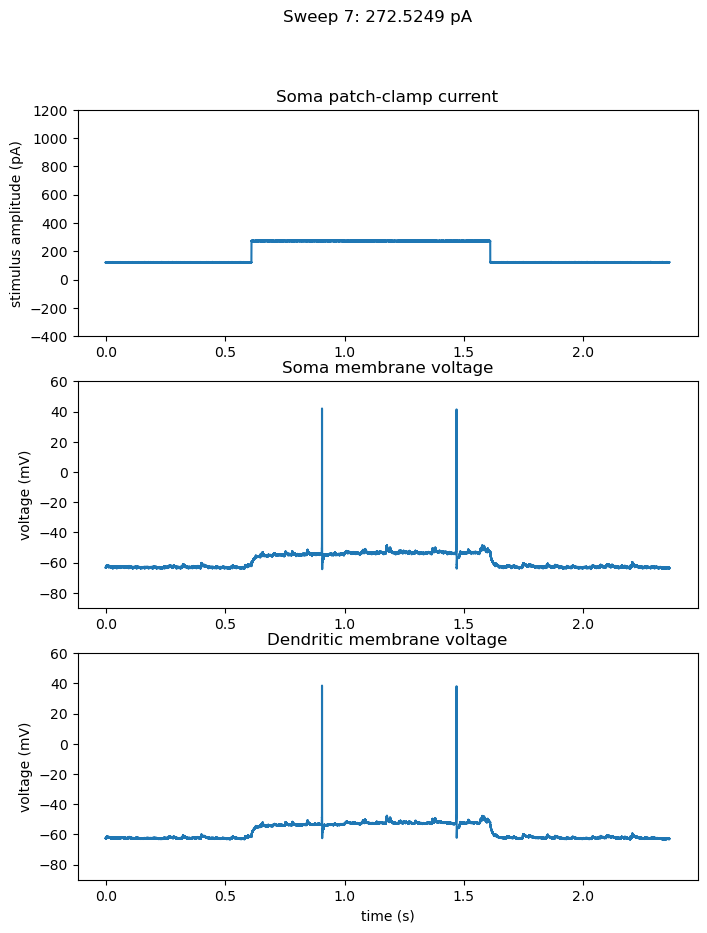

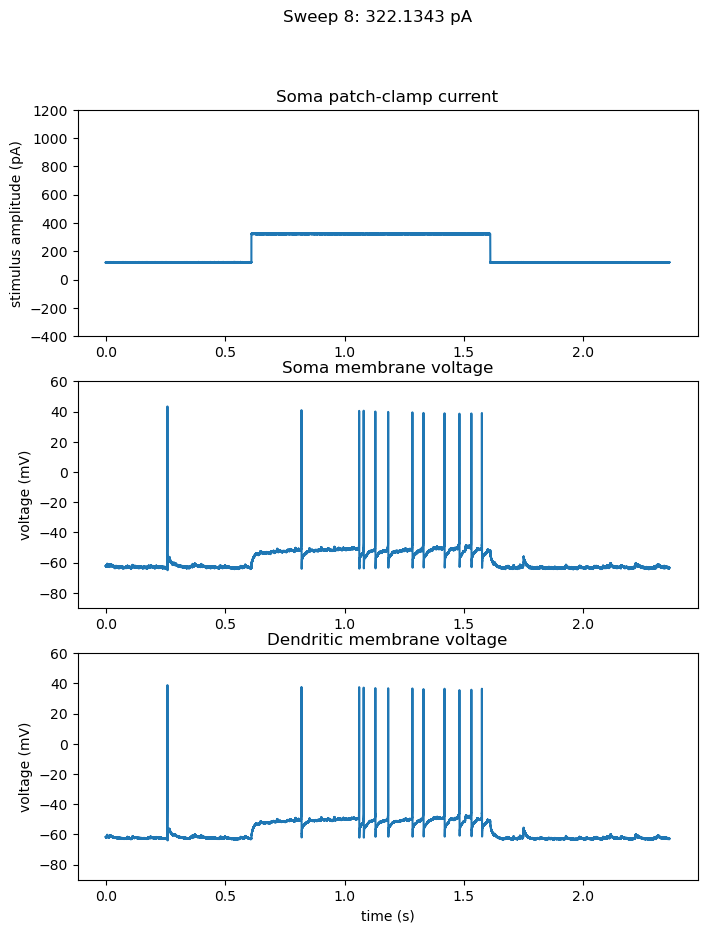

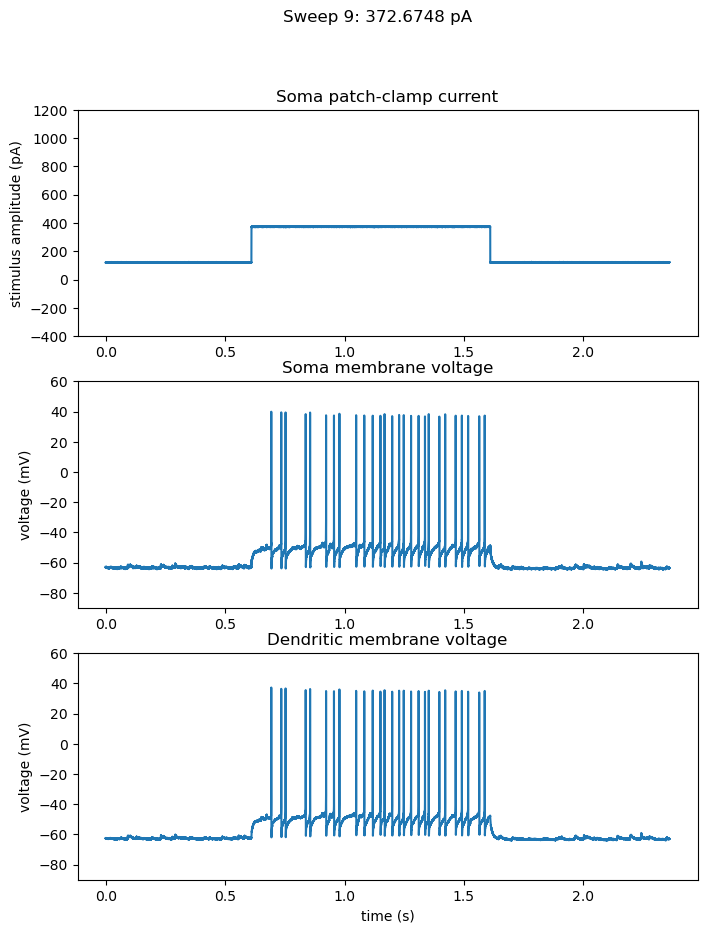

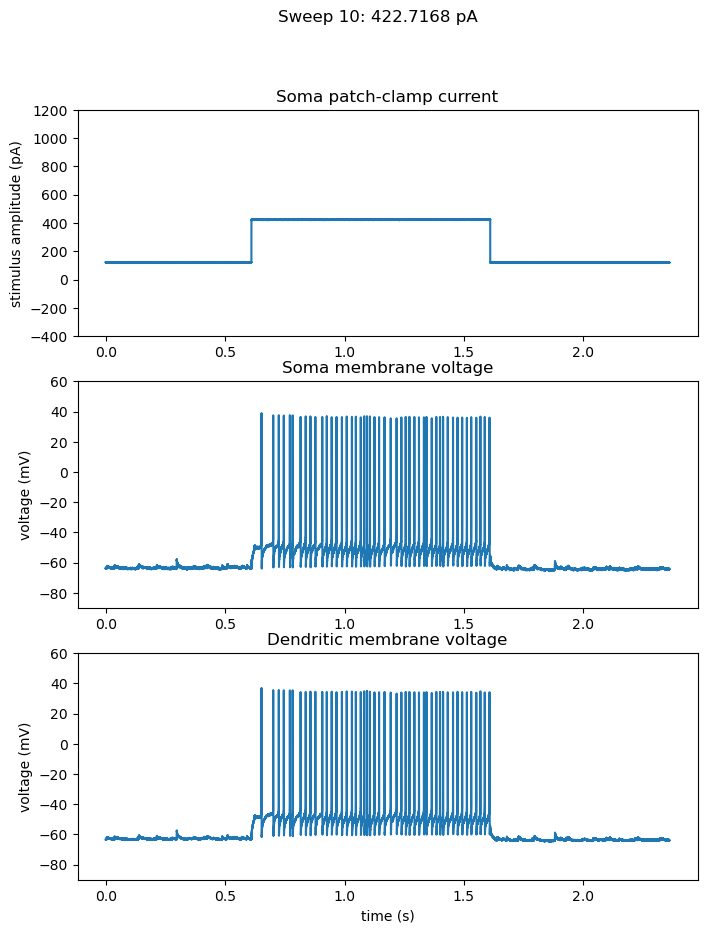

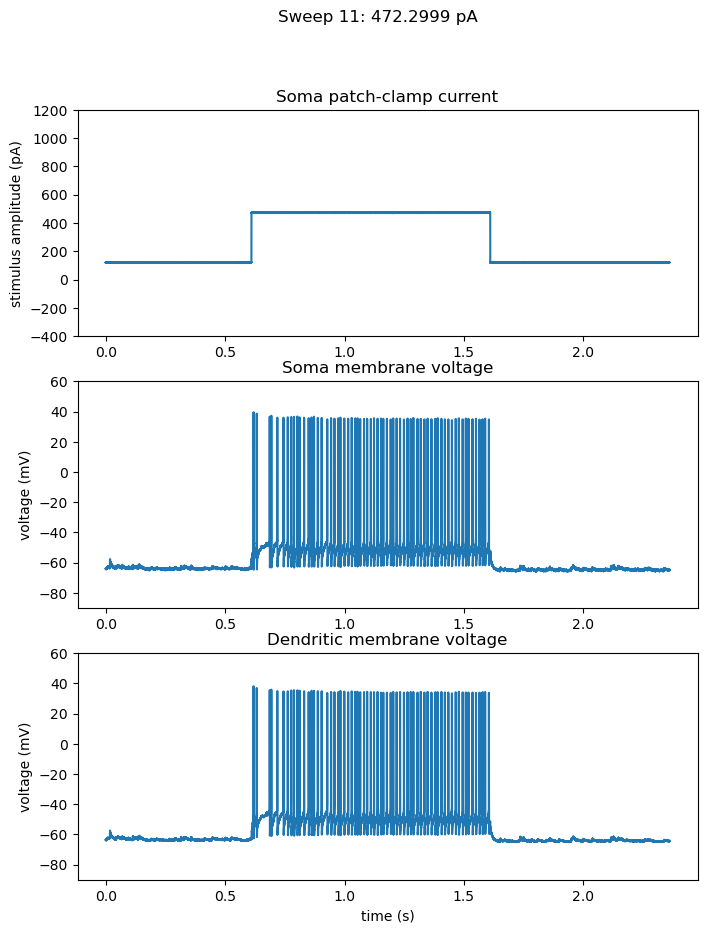

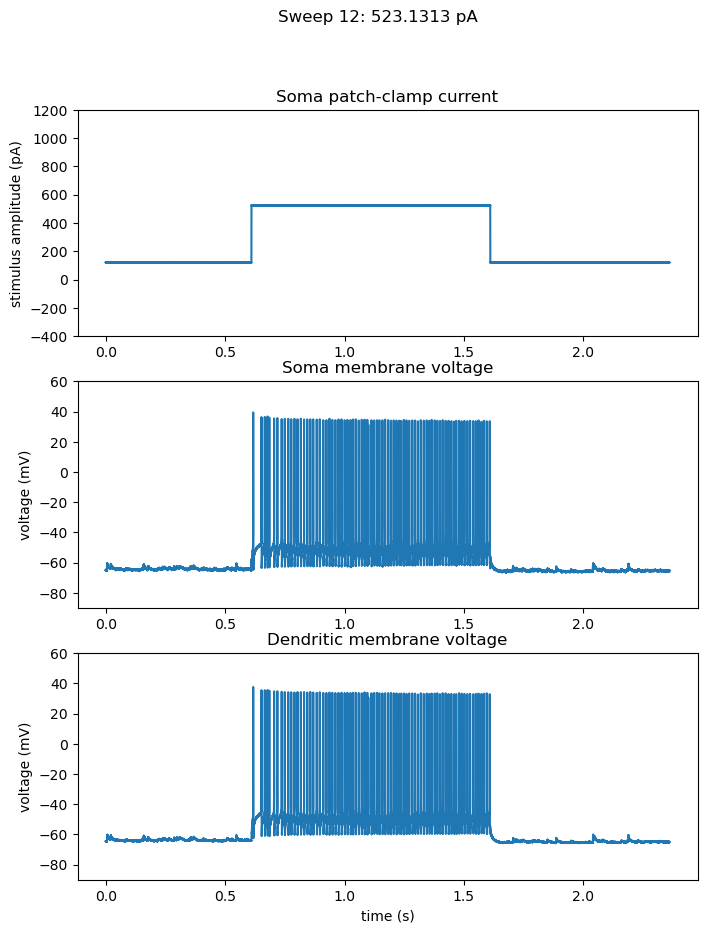

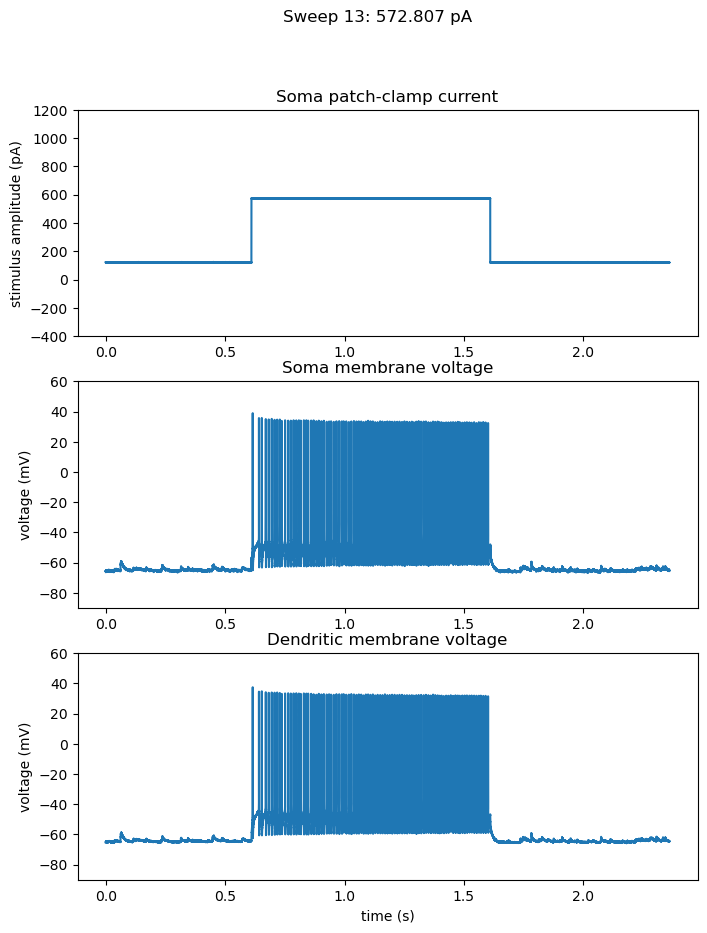

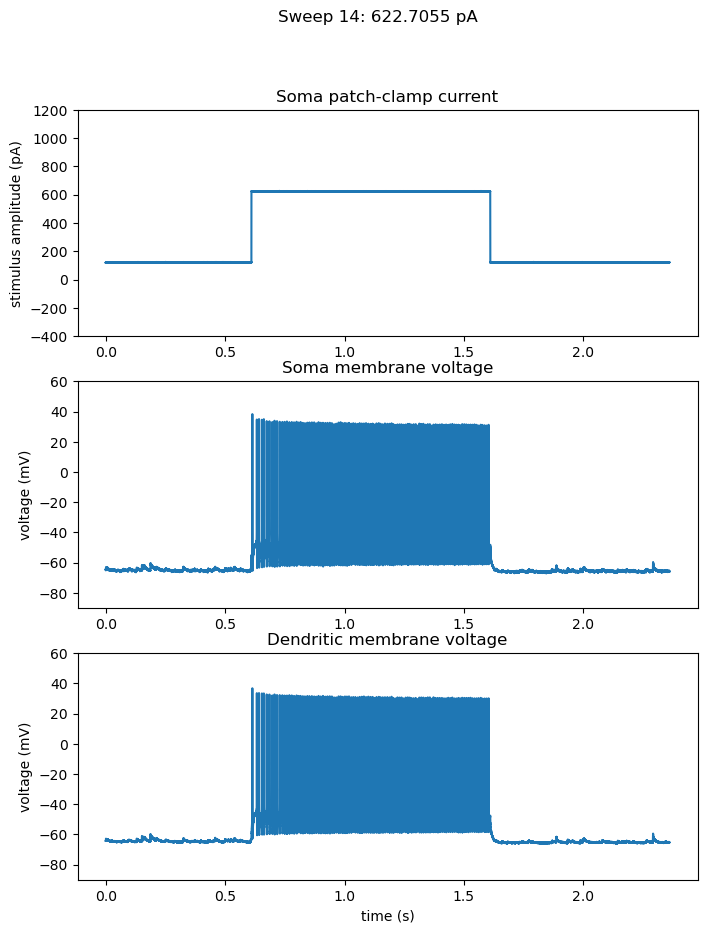

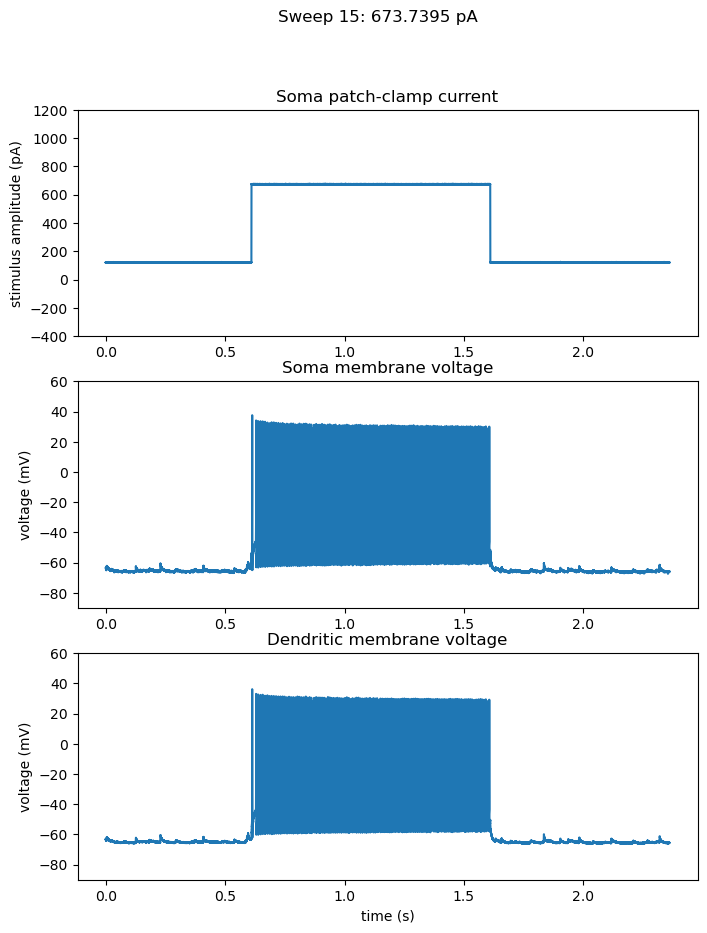

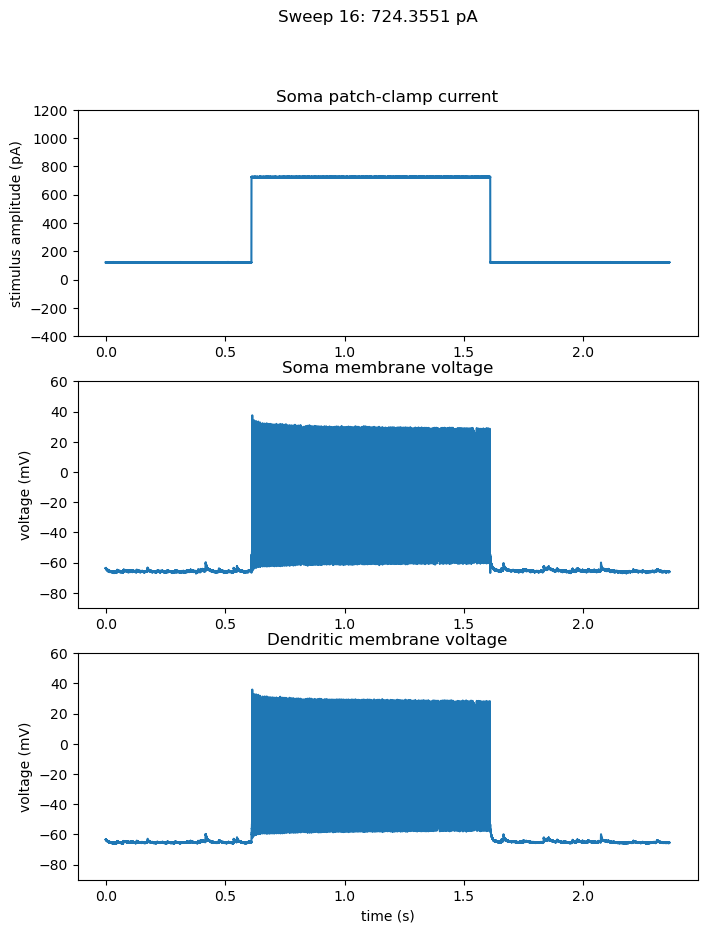

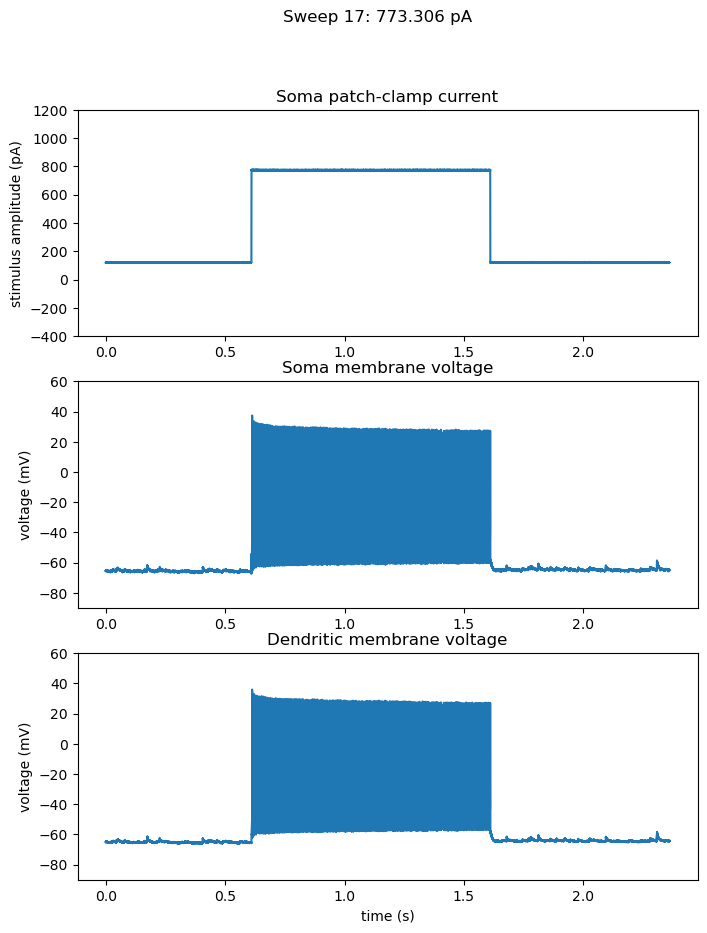

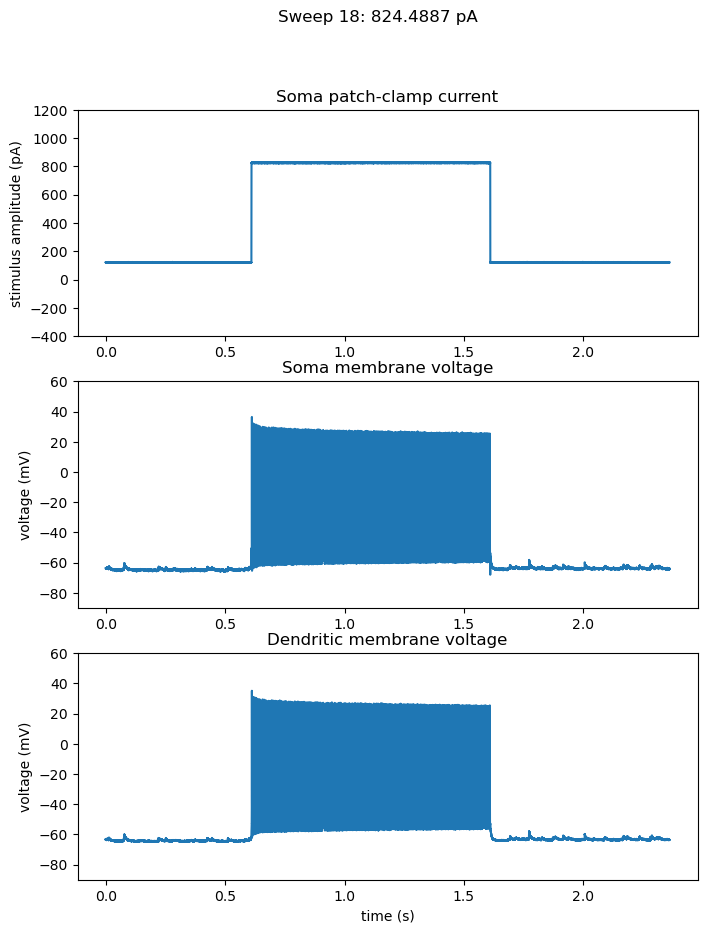

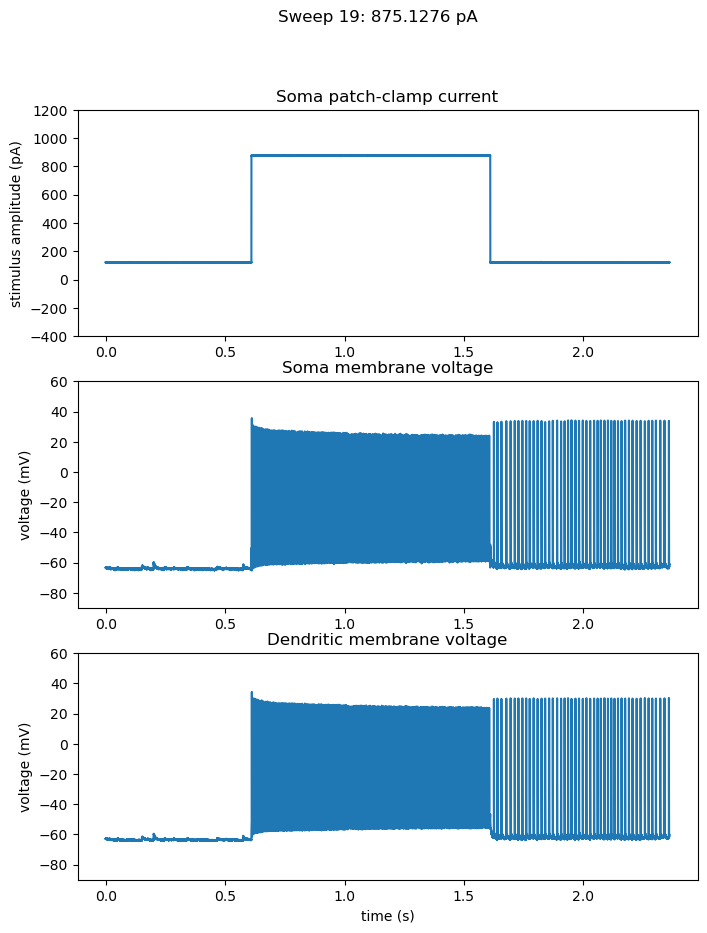

In [14]:
save_figures = True
if plot_figures or save_figures:
    for sweep in range(num_sweeps):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
        ax1.plot(time_vec, soma_current_all[sweep])
        ax1.set_ylim(-400, 1200)
        ax1.set_ylabel('stimulus amplitude (pA)')
        ax1.set_title('Soma patch-clamp current')
        ax2.plot(time_vec, soma_voltage_all[sweep])
        ax2.set_ylim(-90, 60) 
        ax2.set_ylabel('voltage (mV)')
        ax2.set_title('Soma membrane voltage')
        ax3.plot(time_vec, dend_voltage_all[sweep])
        ax3.set_ylim(-90, 60) 
        ax3.set_xlabel('time (s)')
        ax3.set_ylabel('voltage (mV)')
        ax3.set_title('Dendritic membrane voltage')
        
        stim_amp = round(abf_metadata['stim_amps'][sweep]['value'], 4)
        fig_title = "Sweep " + str(sweep) + ': ' + str(stim_amp) + " pA"
        fig.suptitle(fig_title)
        if plot_figures:
            plt.show()
        if save_figures:
            #path_save_fig = os.path.abspath(f"./Figures/{abf_metadata['recording_name']}/sweep_{sweep}.jpg")
            path_save_fig = os.path.abspath(f"./Figures/{abf_metadata['recording_name']}/svg/sweep_{sweep}.svg")
            plt.savefig(path_save_fig, dpi=300, format='svg')   
    save_figures = False
    